In [21]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

In [33]:
#Helper functions
def compute_error(y, y_pred, w_i):
    """
    Calculate the error rate of a weak classifier m.Arguments:
    y:actual target value
    y_pred: predicted value by weak classifier
    w_i: individual weights for each observation

    Note that all arrays should be the same length
    """
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

def compute_alpha(error):
    """
    Calculate the weight of a weak classifier m in the majority vote of the final classifier. This is called 
    alpha in chapter 10.1 of the element of statistical learning. Arguments:
    error: error rate from weak classifier m
    """
    epsilon = 0.01
    return np.log((1 - error + epsilon) / (error + epsilon))

def update_weights_formular1(w_i, alpha, y, y_pred):
    result = w_i * np.exp(-alpha * y * y_pred)
    w_norm = result / np.sum(result)
    return w_norm

def update_weights_formular2(w_i, alpha, y, y_pred):
    result = w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))
    w_norm = result / np.sum(result)
    return w_norm


#Define AdaBoost class
class AIOAdaBoost:
    def __init__(self):
        #self.w_i = None
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M=100):
        """
        Fit model, Arguments:
        X: independent variables
        y: target model
        M: number of boosting rounds. Default is 100
        
        """
        #Clear before calling
        self.alphas = []
        self.training_errors = []
        self.M = M

        #Iterate over M weak classifier
        for m in range(0, M):
            #Set weigths for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y) #At m = 0, weights are all the same and equal to 1/N

            else:
                w_i = update_weights_formular2(w_i, alpha_m, y, y_pred)
                #w_i = update_weights_formular1(w_i, alpha_m, y, y_pred)
            # print(w_i)

            # (a) Fit weak classifier and predict labels
            G_m = DecisionTreeClassifier(max_depth=1) # Stump: Two terminal-node classification tree
            G_m.fit(X, y, sample_weight=w_i)
            y_pred = G_m.predict(X)
            self.G_M.append(G_m) # Save to list of weak classifier

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)
            # print(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)
            # print(alpha_m)

        assert len(self.G_M) == len(self.alphas)

    def predict(self, X):
        """
        Predict using fitted model. Arguments:
        X: independent variables
        """

        #Initalise dataframe with weak predictions for each abservation
        weak_preds = pd.DataFrame(index=range(len(X)), columns=range(self.M))

        #Predict class label for each weak classifier, weighted by alpha_m 
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            #weak_preds.iloc[:, m] = y_pred_m
            weak_preds[weak_preds.columns[m]] = y_pred_m
        
        #Estimate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred
    
    def error_rates(self, X, y):
        """
        Get the error rates of each weak classifier. Arguments:
        X: independent variables
        y: target variables associated to X
        """
        self.prediction_errors = [] #clear before calling

        #Predict class label for each weak classifier
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X)
            error_m = compute_error(y=y, y_pred=y_pred_m, w_i=np.ones(len(y)))
            self.prediction_errors.append(error_m)
             

In [23]:
result = [0.07, 0.07, 0.07, 0.22, 0.07, 0.07, 0.07, 0.22]
w_norm = result / np.sum(result)
print(w_norm)

[0.08139535 0.08139535 0.08139535 0.25581395 0.08139535 0.08139535
 0.08139535 0.25581395]


In [24]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

In [25]:
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
y = y*2 - 1 #Original AdaBoost uses {1, -1} as class labels

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
df = pd.read_csv('spambase/spambase.data', header=None)

names = pd.read_csv('spambase/spambase.names', sep=':', skiprows=range(0, 33), header=None)
col_names = list(names[0])
col_names.append('Spam')
df.columns = col_names
df.head()

df['Spam'] = df['Spam']*2 - 1
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Spam').values, df['Spam'].values, test_size=0.2, random_state=2)


In [34]:
#Fit model
ab = AIOAdaBoost()
ab.fit(X_train, y_train, M=50)

#Predict on test set
y_pred = ab.predict(X_test)
print(f'The accuracy_score of the model is: {round(accuracy_score(y_test, y_pred), 4)}')

The accuracy_score of the model is: 0.9349


In [35]:
# Using the library Scikit_learn implementation of AdaBoost
from sklearn.ensemble import AdaBoostClassifier
ab_sk = AdaBoostClassifier(n_estimators=50)
ab_sk.fit(X_train, y_train)
y_pred_sk = ab_sk.predict(X_test)
print(f'The accuracy score of the model is {round(accuracy_score(y_test, y_pred_sk), 4)}')

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


The accuracy score of the model is 0.9435


In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

In [2]:
class AIVNGradientBooster:

    def __init__(self, max_depth=8, min_samples_split=5, min_samples_leaf=5, max_feature=3, lr=0.1, num_iter=50):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_feature = max_feature
        self.lr = lr
        self.num_iter = num_iter
        self.y_mean = 0

    def __calculate_loss(self, y, y_pred):
        loss = (1/len(y)) * 0.5 * np.sum(np.square(y-y_pred))
        return loss
    
    def __take_gradient(self, y, y_pred):
        #grad = -(y-y_pred) # cho du doan = pred - alpha*residual
        grad = (y - y_pred) # cho du toan pred + alpha*residual
        return grad
    
    def __create_base_model(self, X, y):
        base = DecisionTreeRegressor(max_depth=self.max_depth,
                                     min_samples_split=self.min_samples_split,
                                     min_samples_leaf=self.min_samples_leaf,
                                     max_features=self.max_feature)
        base.fit(X, y)
        return base
    
    def predict(self, models, y, X):
        pred_0 = np.array([self.y_mean] * len(X))
        pred = pred_0.reshape(len(pred_0), 1)

        for i in range(len(models)):
            temp = (models[i].predict(X)).reshape(len(X), 1)
            # pred -= self.lr * temp # For predict = pred - alpha*residual
            pred += self.lr * temp # For predict = pred + alpha*residual

        return pred
    
    def train(self, X, y):
        models = []
        losses = []
        self.y_mean = np.mean(y)
        pred_0 = np.array([np.mean(y)] * len(y))
        pred = pred_0.reshape(len(pred_0), 1)
        #print('Pred_0', pred_0)

        for epoch in range(self.num_iter):
            loss = self.__calculate_loss(y, pred)
            # print('Loss: epoch', epoch, '=', loss)
            losses.append(loss)
            grads = self.__take_gradient(y, pred)
            # print('gradient ', grads)
            base = self.__create_base_model(X, grads)
            r = (base.predict(X)).reshape(len(X), 1)
            # print('r', r)
            # pred -= self.lr*r
            pred += self.lr*r
            models.append(base)

        return models, losses, pred_0

In [4]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'), Text(0.5, 1.0, 'Loss vs Epoch')]

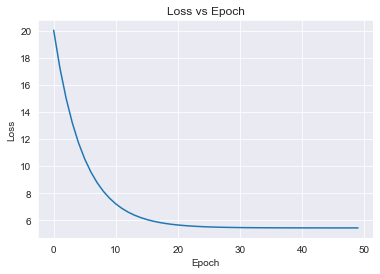

In [8]:
X, y = make_regression(n_samples=15, n_features=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = np.array(y_train).reshape(X_train.shape[0], 1)
y_test = np.array(y_test).reshape(X_test.shape[0], 1)

#Train
G = AIVNGradientBooster()
X_train = np.array([0, -1, 2, 3, 4, 5, 6, 7, 8, 9]).reshape(10, 1)
y_train = np.array([0, -2, 4, 6, 8, 10, 12, 14, 16, 18]).reshape(10, 1)

models, losses, pred_0 = G.train(X_train, y_train)

sns.set_style('darkgrid')
ax = sns.lineplot(x=range(50), y=losses)
ax.set(xlabel='Epoch', ylabel='Loss', title='Loss vs Epoch')

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [10]:
#read data
data = pd.read_csv('advertising.csv')
data.fillna(0, inplace=True)

#X, y
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

#scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = np.array(y_train).reshape(X_train.shape[0], 1)
y_test = np.array(y_test).reshape(X_test.shape[0], 1)

#Train
G = AIVNGradientBooster()
models, losses, pred_0 = G.train(X_train, y_train)

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'), Text(0.5, 1.0, 'Loss vs Epoch')]

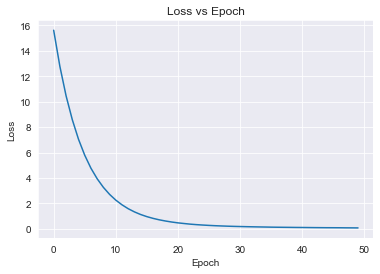

In [11]:
sns.set_style('darkgrid')
ax = sns.lineplot(x=range(50), y=losses)
ax.set(xlabel='Epoch', ylabel='Loss', title='Loss vs Epoch')